In [1]:
# Column Description
# Column 0	Mov_dtservidor	Server Date 
# Column 1	Mov_dtavl	AVL Date
# Column 2	Mov_Idlinha --> Line Code
# Column 3	Mov_longitude	 Longitude
# Column 4	Mov_latitude	 Latitude
# Column 5	Mov_Idavl	 AVL Code (table av)
# Column 6	Mov_Evento	Trip event (0=open 64=closed)
# Column 7	Mov_Idponto	point (gtfs information)

In [2]:
import pandas as pd

In [1]:
import pyspark

conf = pyspark.SparkConf()
conf = (conf.setMaster("local[*]")
        .set('spark.executor.memory', "64G")\
        .set('spark.driver.memory', "64G")\
        .set('spark.default.parallelism', '128') \
        .set('spark.jars.packages', 'com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.3,com.databricks:spark-xml_2.11:0.6.0'))

sparkContext = pyspark.SparkContext(conf=conf)
sparkSession = pyspark.sql.SparkSession(sparkContext)

AWS_ACCESS_KEY_ID='your_key'

AWS_SECRET_ACCESS_KEY='your_key'

hadoop_conf = sparkSession._jsc.hadoopConfiguration()
hadoop_conf.set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
hadoop_conf.set("fs.s3a.access.key", AWS_ACCESS_KEY_ID)
hadoop_conf.set("fs.s3a.secret.key", AWS_SECRET_ACCESS_KEY)
hadoop_conf.set("fs.s3a.connection.maximum", "100")

In [2]:
df = sparkSession.read.option("header", "false").csv('s3a://mobility-traces-bus-sp/MO_15101.csv')

In [3]:
column_names = "dtservidor,dtavl,idlinha,latitude,longitude,idavl,evento,idponto".split(",")

for i in range(len(column_names)):
    df = df.withColumnRenamed("_c%s" % i, column_names[i])

In [4]:
df.show()

+--------------------+--------------------+-------+----------+----------+-----+------+-------+
|          dtservidor|               dtavl|idlinha|  latitude| longitude|idavl|evento|idponto|
+--------------------+--------------------+-------+----------+----------+-----+------+-------+
|2015-10-01 04:00:...|2015-10-01 03:59:...|   1038|-23.562598|-46.445810|43169|    64|   7823|
|2015-10-01 04:00:...|2015-10-01 03:59:...|  33093|-23.579135|-46.481513|57458|     0|      0|
|2015-10-01 04:00:...|2015-10-01 03:59:...|  34233|-23.767883|-46.716332|11109|     0|   7774|
|2015-10-01 04:00:...|2015-10-01 03:59:...|    898|-23.507058|-46.400353|42695|     0|      0|
|2015-10-01 04:00:...|2015-10-01 03:59:...|   2036|-23.738058|-46.697865|13878|     0|      0|
|2015-10-01 04:00:...|2015-10-01 03:59:...|   1816|-23.448900|-46.599482|44684|    64|      0|
|2015-10-01 04:00:...|2015-10-01 03:59:...|  33486|-23.552840|-46.557060|51994|     0|      0|
|2015-10-01 04:00:...|2015-10-01 03:57:...|   1044

In [5]:
from dateutil import parser
from pyspark.sql.functions import *# udf, struct, col, countDistinct
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, BooleanType

# getting hour integer from hour ex: 11:52 => 11h
def get_hour(row):
    date = parser.parse(row)
    return date.hour

# getting if the trip is opened. It is opened if at least half of the events column of all point/registers is opened
def get_open(row):
    if len(row) != 0:
        meio = int(len(row)/2)
        return int(row[meio]) == 0
    else:
        return False

udf_get_hour = udf(get_hour, IntegerType())
udf_get_open = udf(get_open, BooleanType())

In [8]:
# defining an hour for each row
df = df.withColumn("hour", udf_get_hour(df["dtavl"]))

In [13]:
# aggregating by hour and bus
df_2 = df.groupBy("hour", "idavl").agg(collect_list("evento").alias("list_events"))

In [14]:
# defining if a trace/trajectory is open/closed
df_2 = df_2.withColumn("open", udf_get_open(df_2["list_events"]))

In [15]:
# plot just the open points
df_pd = df_2.filter("open == true").groupBy("hour").agg(count("idavl").alias("onibus")).toPandas()
df_pd

,hour,onibus
0,12,4122
1,22,4560
2,1,5882
3,13,4174
4,6,4100
5,16,3823
6,3,7106
7,20,4300
8,5,5579
9,19,3569


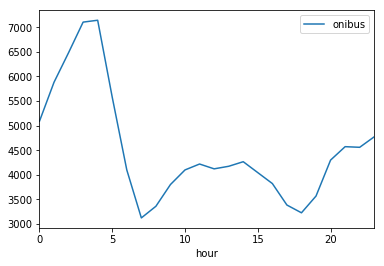

In [18]:
df_pd.sort_values("hour").plot(x = "hour", y = "onibus")

In [19]:
df_pd_64 = df_2.filter("open == false").groupBy("hour").agg(count("idavl").alias("onibus")).toPandas()
df_pd_64 #onibus funcionando

,hour,onibus
0,12,10264
1,22,9730
2,1,8047
3,13,10231
4,6,10393
5,16,10655
6,3,6973
7,20,10117
8,5,8894
9,19,10877


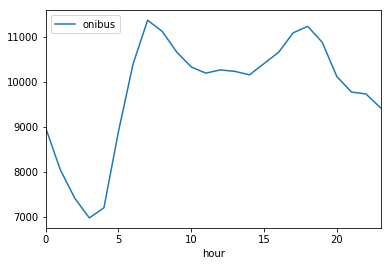

In [22]:
df_pd_64.sort_values("hour").plot(x = "hour", y = "onibus")

# Logic Summary - Calculating the number of buses actives/inactives per hour

In [16]:
distinct_bus_hour = df.filter("evento == 0").groupBy("hour").agg(countDistinct("idavl").alias("onibus")).toPandas()

In [20]:
distinct_bus_hour_64 = df.filter("evento == 64").groupBy("hour").agg(countDistinct("idavl").alias("onibus")).toPandas()

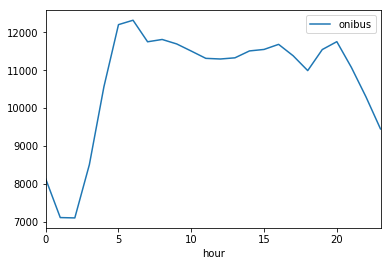

In [18]:
distinct_bus_hour.sort_values("hour").plot(x = "hour", y = "onibus")

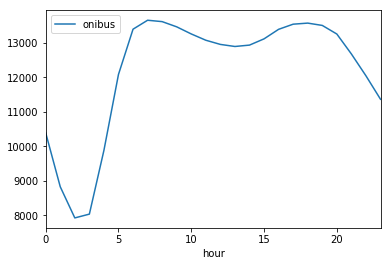

In [21]:
distinct_bus_hour_64.sort_values("hour").plot(x = "hour", y = "onibus")

In [17]:
df.groupBy("idlinha").count().show()

+-------+-----+
|Idlinha|count|
+-------+-----+
|   2088|16247|
|    691|11455|
|    829|23826|
|    675|28460|
|  32773| 5563|
|  35004| 4056|
|   2069| 9736|
|   2136|22023|
|   2162| 4805|
|   1159| 1855|
|  33783| 7016|
|  33665|10966|
|   2294|  313|
|  34657| 3016|
|  33174|12583|
|  32939|29329|
|    125|33374|
|    800|16262|
|  33615|13753|
|   1372|13846|
+-------+-----+
only showing top 20 rows



In [21]:
df.select("idavl").distinct().count()

14687

In [9]:
# base map of Sao Paulo
!unzip DISTRITO_MUNICIPAL_SP_SMDU

Archive:  DISTRITO_MUNICIPAL_SP_SMDU.zip
  inflating: DISTRITO_MUNICIPAL_SP_SMDUPolygon.cst  
  inflating: DISTRITO_MUNICIPAL_SP_SMDUPolygon.dbf  
  inflating: DISTRITO_MUNICIPAL_SP_SMDUPolygon.shx  
  inflating: DISTRITO_MUNICIPAL_SP_SMDUPolygon.prj  
  inflating: DISTRITO_MUNICIPAL_SP_SMDUPolygon.shp  
  inflating: wfsrequest.txt          


In [6]:
import geopandas as gpd

sp = gpd.read_file("DISTRITO_MUNICIPAL_SP_SMDUPolygon.shp")

In [3]:
# 96 regions/neighbourhoods
sp.plot()

NameError: name 'sp' is not defined

In [15]:
sp.head()

,Codigo,Nome,geometry
0,51,MANDAQUI,"POLYGON ((-46.65470 -23.43063, -46.65468 -23.4..."
1,52,MARSILAC,"POLYGON ((-46.60987 -23.90550, -46.60990 -23.9..."
2,32,MOEMA,"POLYGON ((-46.65361 -23.57219, -46.65359 -23.5..."
3,57,PARQUE DO CARMO,"POLYGON ((-46.44461 -23.59272, -46.44470 -23.5..."
4,60,PERDIZES,"POLYGON ((-46.66355 -23.53692, -46.66362 -23.5..."


In [20]:
len(sp)

96

In [7]:
from shapely.geometry import Point, Polygon

# getting region of a trace/point/row
def get_bairro(row, sp):
    point = Point((float(row[0]), float(row[1])))
    for i in range(96):
        if point.within(sp.loc[i, "geometry"]):
            return sp.loc[i, "Nome"]
    return "Fora"

def get_bairro_udf(sp):
    return udf(lambda x: get_bairro(x, sp))

In [8]:
df = df.withColumn("hour", udf_get_hour(df["dtavl"]))

df_new = df.withColumn("bairro", get_bairro_udf(sparkContext.broadcast(sp).value)
                                                           (struct(df["longitude"],
                                                             df["latitude"])))

In [ ]:
df_bairros = df_new.groupBy("hour", "bairro").agg(countDistinct("idavl").alias("count")).toPandas()
df_bairros.head(10)

In [56]:
df_bairros.sort_values("count", ascending = False).head()

,hour,bairro,count
197,8,SANTO AMARO,1747
684,9,SANTO AMARO,1740
450,7,SANTO AMARO,1732
1190,6,SANTO AMARO,1727
1958,16,SANTO AMARO,1666


In [24]:
df_final = pd.merge(df_bairros, sp, left_on = "bairro", right_on = "Nome").drop(columns = ["Nome"])

In [28]:
geo_df = gpd.GeoDataFrame(df_final, geometry = "geometry")
geo_df.head()

,hour,bairro,count,Codigo,geometry
0,4,JOSE BONIFACIO,824,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."
1,10,JOSE BONIFACIO,624,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."
2,7,JOSE BONIFACIO,614,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."
3,21,JOSE BONIFACIO,706,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."
4,6,JOSE BONIFACIO,669,47,"POLYGON ((-46.42933 -23.53341, -46.42933 -23.5..."


Hora:  0


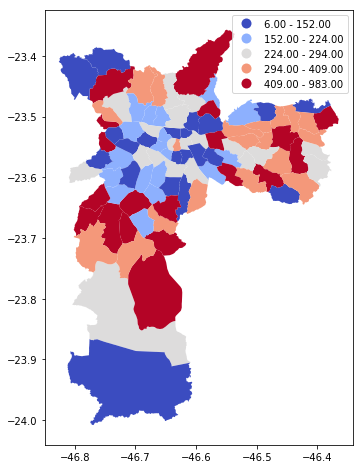

Hora:  1


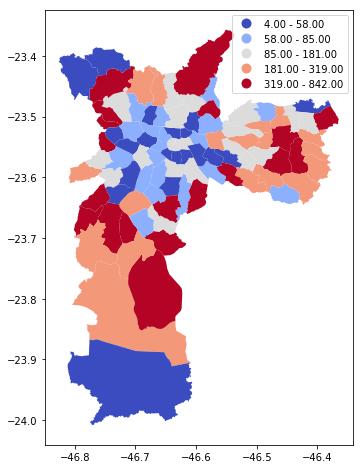

Hora:  2


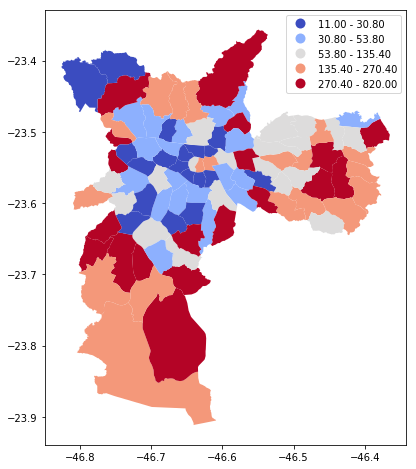

Hora:  3


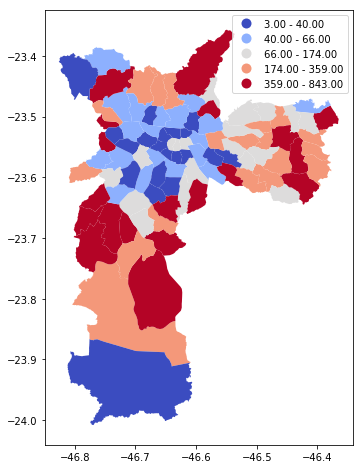

Hora:  4


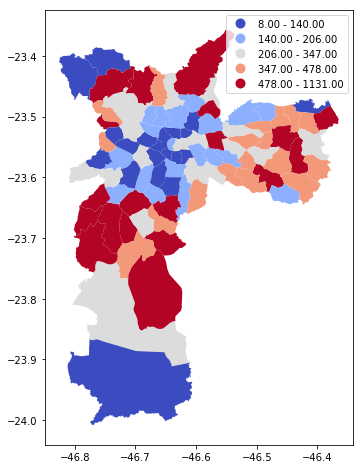

Hora:  5


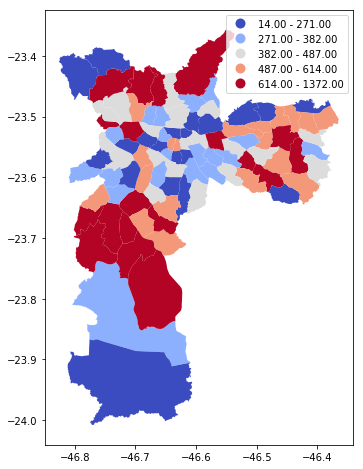

Hora:  6


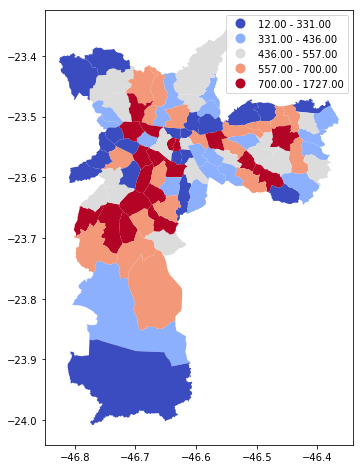

Hora:  7


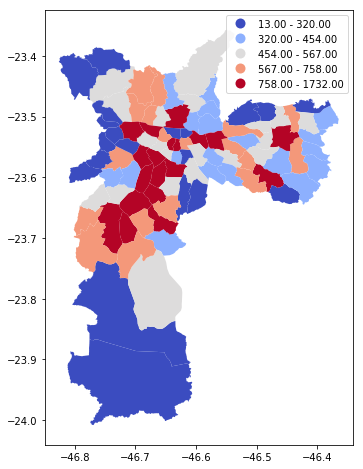

Hora:  8


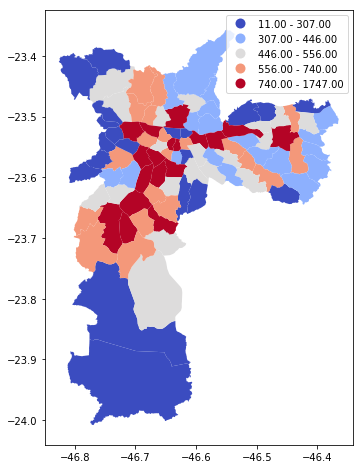

Hora:  9


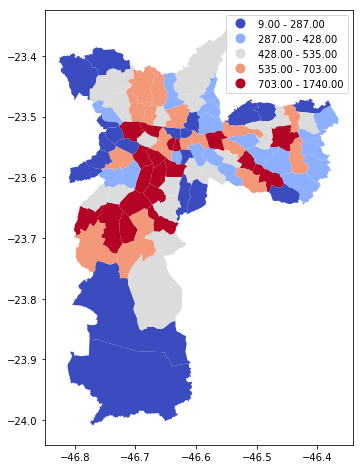

Hora:  10


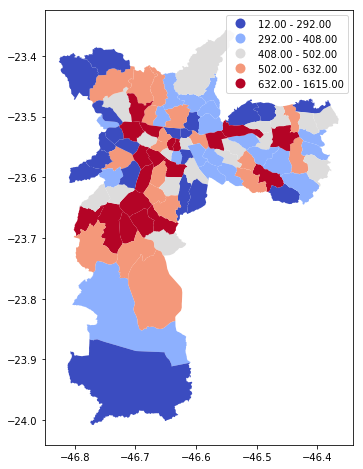

Hora:  11


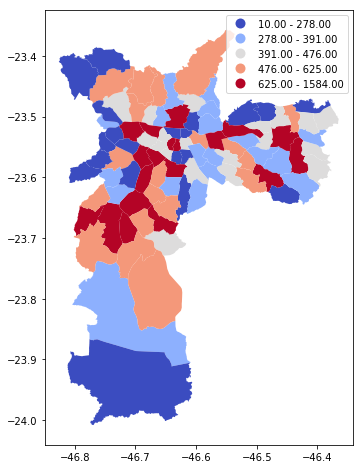

Hora:  12


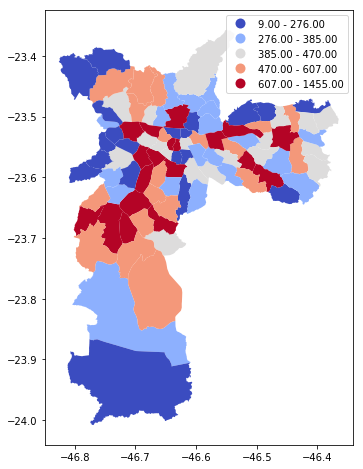

Hora:  13


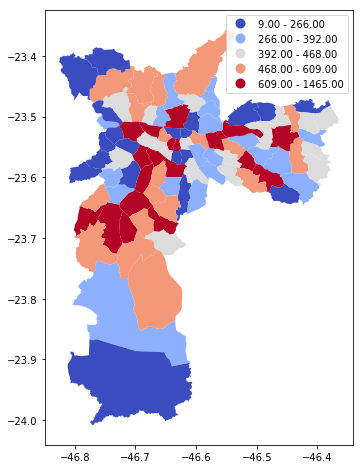

Hora:  14


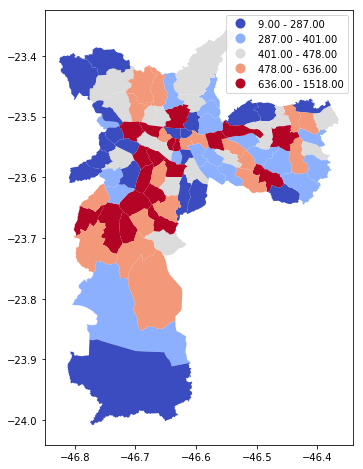

Hora:  15


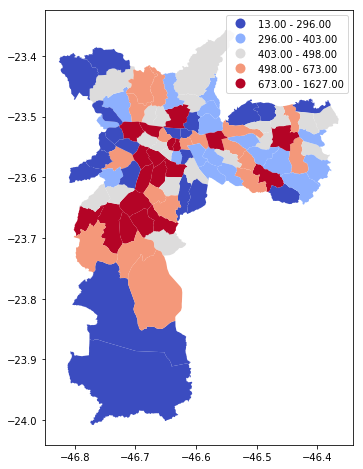

Hora:  16


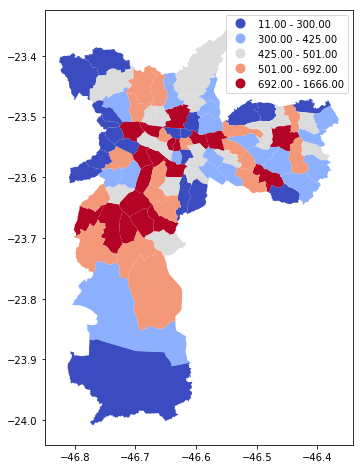

Hora:  17


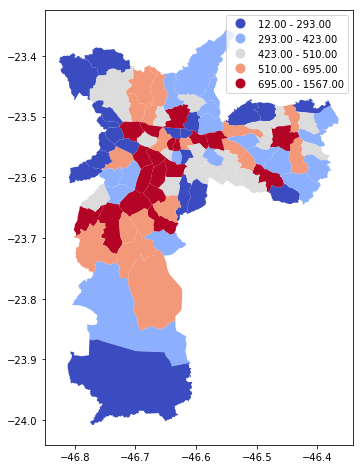

Hora:  18


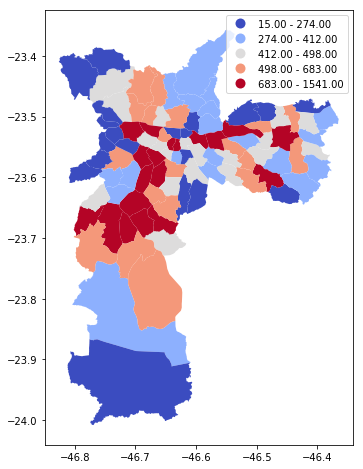

Hora:  19


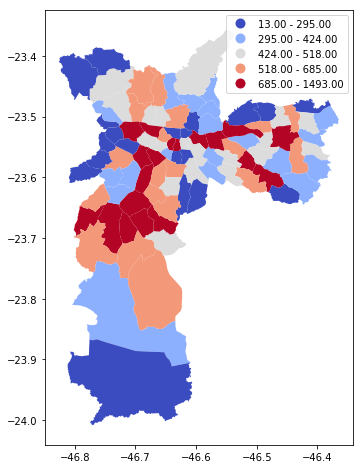

Hora:  20


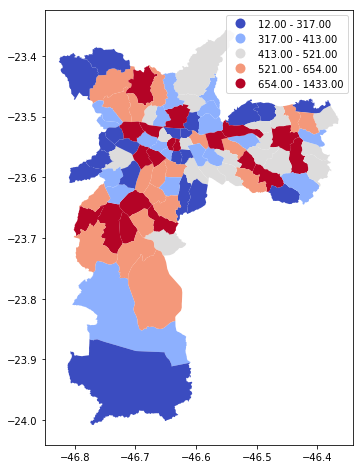

Hora:  21


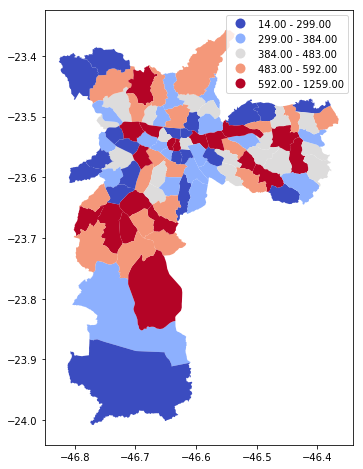

Hora:  22


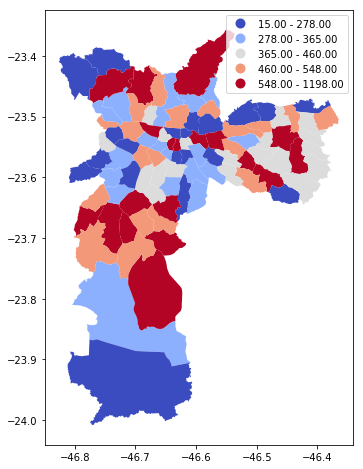

Hora:  23


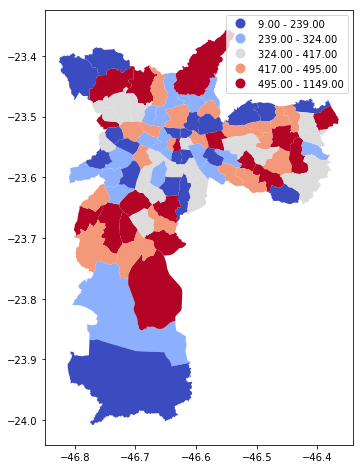

In [67]:
#color maps https://matplotlib.org/tutorials/colors/colormaps.html

# plotting buses in Sao Paulo map for a work day (01/10/2015)
import matplotlib.pyplot as plt

for hour in range(24):
    print("Hora: ", hour)
    geo_df[geo_df["hour"] == hour].plot(column = "count",legend = True,  cmap='coolwarm', figsize = (8,8),scheme='quantiles' )
    plt.show()

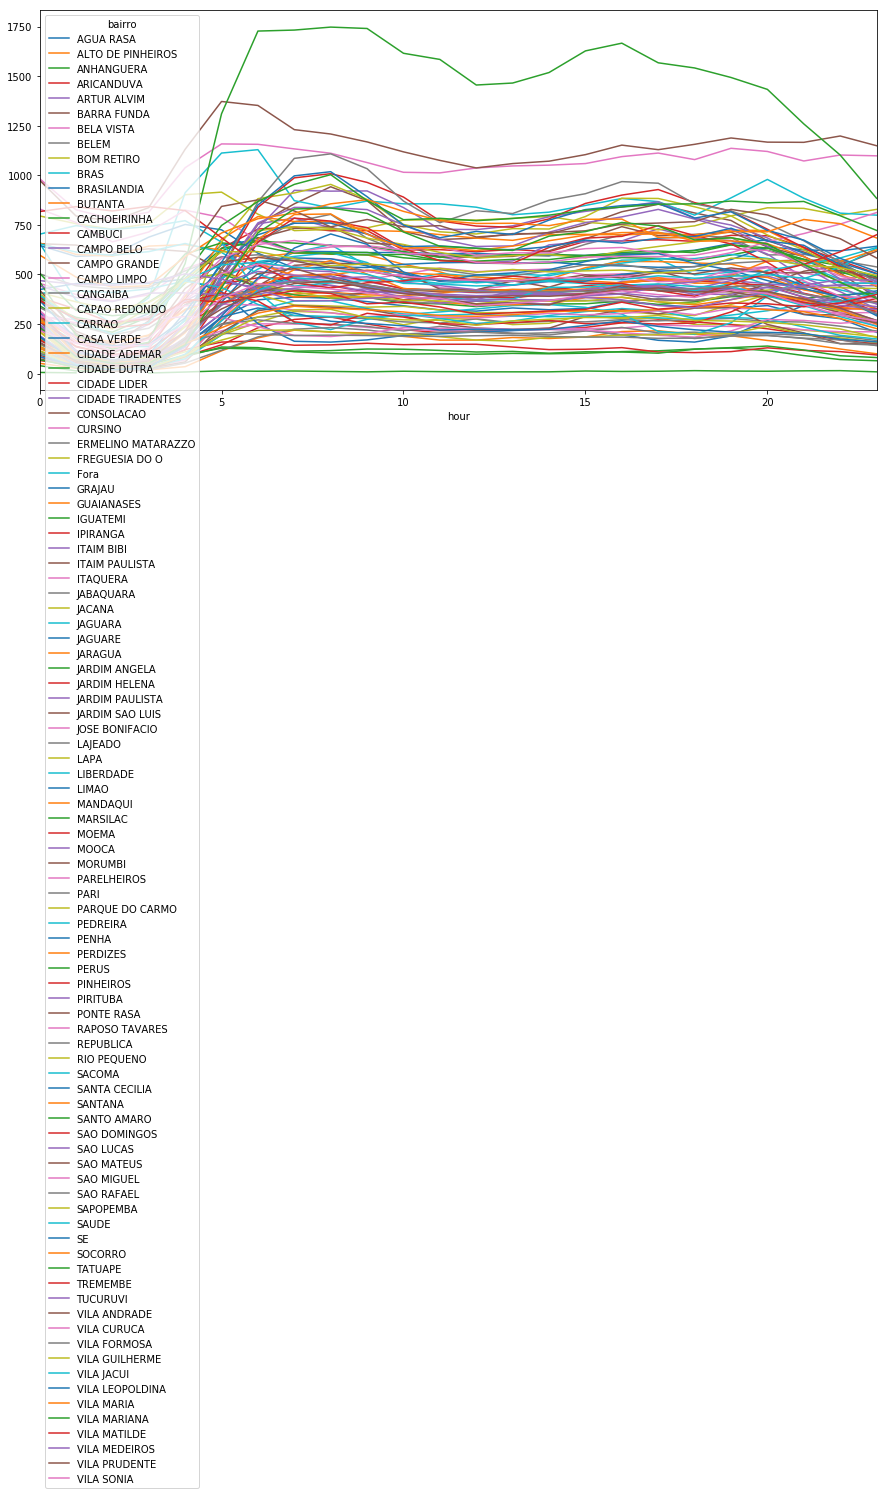

In [64]:
df_bairros.pivot_table(index=df_bairros['hour'],columns='bairro',values='count').plot(figsize=(15,7), kind = "line")

In [44]:
!pip install mapclassify

  Running setup.py bdist_wheel for mapclassify ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/fc/b8/58/56b650743289cbecb476ef1fc50ab0aeaa0b12e56ad912d624
Successfully built mapclassify
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
